In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import time
from xgboost import XGBClassifier

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

Loading and Understanding the Dataset

In [9]:
df_original = pd.read_csv("Drug_Consumption.csv")
df_quantified = pd.read_csv("Drug_Consumption_Quantified.csv")

print("Shape of original dataset: ", df_original.shape)
print("Shape of quantified dataset: ", df_quantified.shape)

Shape of original dataset:  (1884, 32)
Shape of quantified dataset:  (1884, 32)


In [10]:
df_original.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0


In [11]:
df_quantified.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0


We will be working with the Quantified Dataset. Dropping the ID feature since there should not be a correlation between the prediction and ID.

In [13]:
df = df_quantified.drop('ID', axis = 1)
print("df.shape: ", df.shape)
df.head()

df.shape:  (1884, 31)


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0


Pre-Processing 1 : Check for missing values


In [18]:
print(df.isnull().mean() * 100)

print("Number of rows with missing values: ", df.isnull().any(axis=1).sum())
print("Number of columns with missing values: ", df.isnull().any(axis=0).sum())

Age          0.0
Gender       0.0
Education    0.0
Country      0.0
Ethnicity    0.0
Nscore       0.0
Escore       0.0
Oscore       0.0
AScore       0.0
Cscore       0.0
Impulsive    0.0
SS           0.0
Alcohol      0.0
Amphet       0.0
Amyl         0.0
Benzos       0.0
Caff         0.0
Cannabis     0.0
Choc         0.0
Coke         0.0
Crack        0.0
Ecstasy      0.0
Heroin       0.0
Ketamine     0.0
Legalh       0.0
LSD          0.0
Meth         0.0
Mushrooms    0.0
Nicotine     0.0
Semer        0.0
VSA          0.0
dtype: float64
Number of rows with missing values:  0
Number of columns with missing values:  0


We observe that there are no missing values in the dataset

Pre-Processing 2 : Visualzing the correlation matrix

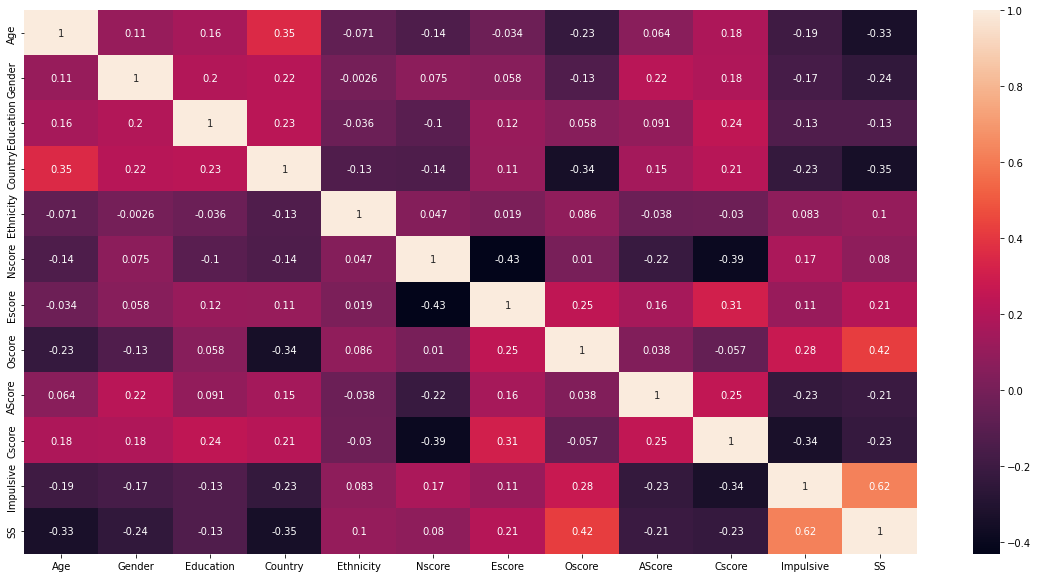

In [16]:
corr = df.corr()
plt.figure(figsize = (20, 10))
sns.heatmap(corr, annot = True)

We observe that none of the features are highly correlated with one another (no pair of features has correlation more than 0.90)

Pre-Processing 3 : Subset Datasets by Target
  * This a multi-class classification with 18 targets and 7 classes
  * We subset the dataset into 12 different subsets each having one target
  * For each subset, we do a multi-class classification over the 7 classes
  * 12 targets refer to 12 out of the 18 drugs we choose to model
      * df_alcohol
      * df_caff
      * df_cannabis
      * df_choc
      * df_coke
      * df_crack
      * df_ecstasy
      * df_heroin
      * df_lsd
      * df_mushrooms
      * df_nicotine
      * df_semer
  * 7 classes refer to the following labels
      * "Never Used" ; Embedded as CLO in the dataset
      * "Used over a Decade" ; Embedded as CL1 in the dataset
      * "Used in Last Decade" ; Embedded as CL2 in the dataset
      * "Used in Last Year" ; Embedded as CL3 in the dataset
      * "Used in Lasr Month" ; Embedded as CL4 in the dataset
      * "Used in Last Week" ; Embedded as CL5 in the dataset
      * "Used in Last Day" ; Embedded as CL6 in the dataset


In [29]:
print("Following features are present in the dataset")

for col in df.columns:
  print(col)

Following features are present in the dataset
Age
Gender
Education
Country
Ethnicity
Nscore
Escore
Oscore
AScore
Cscore
Impulsive
SS
Alcohol
Amphet
Amyl
Benzos
Caff
Cannabis
Choc
Coke
Crack
Ecstasy
Heroin
Ketamine
Legalh
LSD
Meth
Mushrooms
Nicotine
Semer
VSA


In [31]:
drugs_to_ignore = ['Amphet', 'Amyl', 'Benzos', 'Ketamine', 'Legalh', 'Meth', 'VSA']
drugs_to_consider = ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']

Pre-Processing 3.1 : Creating subsets to perform prediction over only "drugs_to_consider" attributes

In [40]:
non_alcohol_feature = drugs_to_ignore + ['Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']
non_caff_features = drugs_to_ignore + ['Alcohol', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']
non_cannabis_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']
non_choc_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']
non_coke_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']
non_crack_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']
non_ecstasy_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']
non_heroin_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'LSD', 'Mushrooms', 'Nicotine', 'Semer']
non_lsd_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Mushrooms', 'Nicotine', 'Semer']
non_mushrooms_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Nicotine', 'Semer']
non_nicotine_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Semer']
non_semer_features = drugs_to_ignore + ['Alcohol', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Mushrooms', 'Nicotine']

In [41]:
df_alcohol = df.drop(non_alcohol_feature, axis = 1)

df_caff = df.drop(non_caff_features, axis = 1)

df_cannabis = df.drop(non_cannabis_features, axis = 1)

df_choc = df.drop(non_choc_features, axis = 1)

df_coke = df.drop(non_coke_features, axis = 1)

df_crack = df.drop(non_crack_features, axis = 1)

df_ecstasy = df.drop(non_ecstasy_features, axis = 1)

df_heroin = df.drop(non_heroin_features, axis = 1)

df_lsd = df.drop(non_lsd_features, axis = 1)

df_mushrooms = df.drop(non_mushrooms_features, axis = 1)

df_nicotine = df.drop(non_nicotine_features, axis = 1)

df_semer = df.drop(non_semer_features, axis = 1)

In [42]:
df_alcohol.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Alcohol
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL2


In [43]:
df_caff.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Caff
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL6
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL5
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL6
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL6


In [44]:
df_cannabis.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Cannabis
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL4
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL3
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL2
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL3
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0


In [55]:
df_choc.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Choc
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL6
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL4
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL6
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL4


In [56]:
df_coke.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Coke
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL3
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL2
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL0
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0


In [47]:
df_crack.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Crack
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL0
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL0
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL0
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0


In [48]:
df_ecstasy.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Ecstasy
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL4
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL0
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL1
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0


In [49]:
df_heroin.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Heroin
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL0
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL0
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL0
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0


In [57]:
df_lsd.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,LSD
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL2
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL0
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL0
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0


In [50]:
df_mushrooms.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Mushrooms
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL0
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL1
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL0
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL2
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0


In [52]:
df_nicotine.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Nicotine
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL4
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL2
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL2
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL6


In [54]:
df_semer.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Semer
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL0
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL0
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL0
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,CL0
